In [64]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler


spark = SparkSession.builder.appName("Stress Levels Analysis").getOrCreate()
sc = spark.sparkContext


In [13]:
freq_df = spark.read.csv("../dataset/Train Data/frequency_domain_features_train.csv", header=True, inferSchema=True)
non_linear_df = spark.read.csv("../dataset/Train Data/heart_rate_non_linear_features_train.csv", header=True, inferSchema=True)
time_df = spark.read.csv("../dataset/Train Data/time_domain_features_train.csv", header=True, inferSchema=True)

# join the dataframes on the 'uuid' column
df = freq_df.join(non_linear_df, 'uuid').join(time_df, 'uuid')
df = df.drop('uuid')
df.head()

Row(VLF=321.28385171441187, VLF_PCT=49.78199123801968, LF=277.0830668762101, LF_PCT=42.93320916638017, LF_NU=85.49365103238536, HF=47.01476206228013, HF_PCT=7.284799595600161, HF_NU=14.506348967614631, TP=645.3816806529021, LF_HF=5.893533322771263, HF_LF=0.1696774999364522, SD1=6.590099245070281, SD2=47.93622907469599, sampen=2.132869528665783, higuci=1.3356884224184489, datasetId=2, condition='no stress', MEAN_RR=708.4158226733333, MEDIAN_RR=710.497445, SDRR=34.21484667481067, RMSSD=9.316827583370278, SDSD=9.316698536105333, SDRR_RMSSD=3.6723709190326943, HR=84.89988540689204, pNN25=0.5333333333333333, pNN50=0.0, KURT=0.5870881986947318, SKEW=-0.4883014530949298, MEAN_REL_RR=6.845446974626326e-05, MEDIAN_REL_RR=0.0003478729153788048, SDRR_REL_RR=0.01325647310015597, RMSSD_REL_RR=0.009103727154669014, SDSD_REL_RR=0.009103724917169908, SDRR_RMSSD_REL_RR=1.456158875912394, KURT_REL_RR=0.5870881986947318, SKEW_REL_RR=-0.4883014530949298)

In [58]:
freq_df = pd.read_csv("../dataset/Train Data/frequency_domain_features_train.csv")
non_linear_df = pd.read_csv("../dataset/Train Data/heart_rate_non_linear_features_train.csv")
time_df = pd.read_csv("../dataset/Train Data/time_domain_features_train.csv")

# join the dataframes on the 'uuid' column
df = pd.merge(freq_df, non_linear_df, on='uuid')
df = pd.merge(df, time_df, on='uuid')
df = df.drop(columns=['uuid', 'datasetId'])

# change condition column to categorical
df['condition'] = df['condition'].astype('category')
df['condition'] = df['condition'].cat.codes

In [59]:
df['condition'].value_counts()

condition
1    200082
0    105150
2     64057
Name: count, dtype: int64

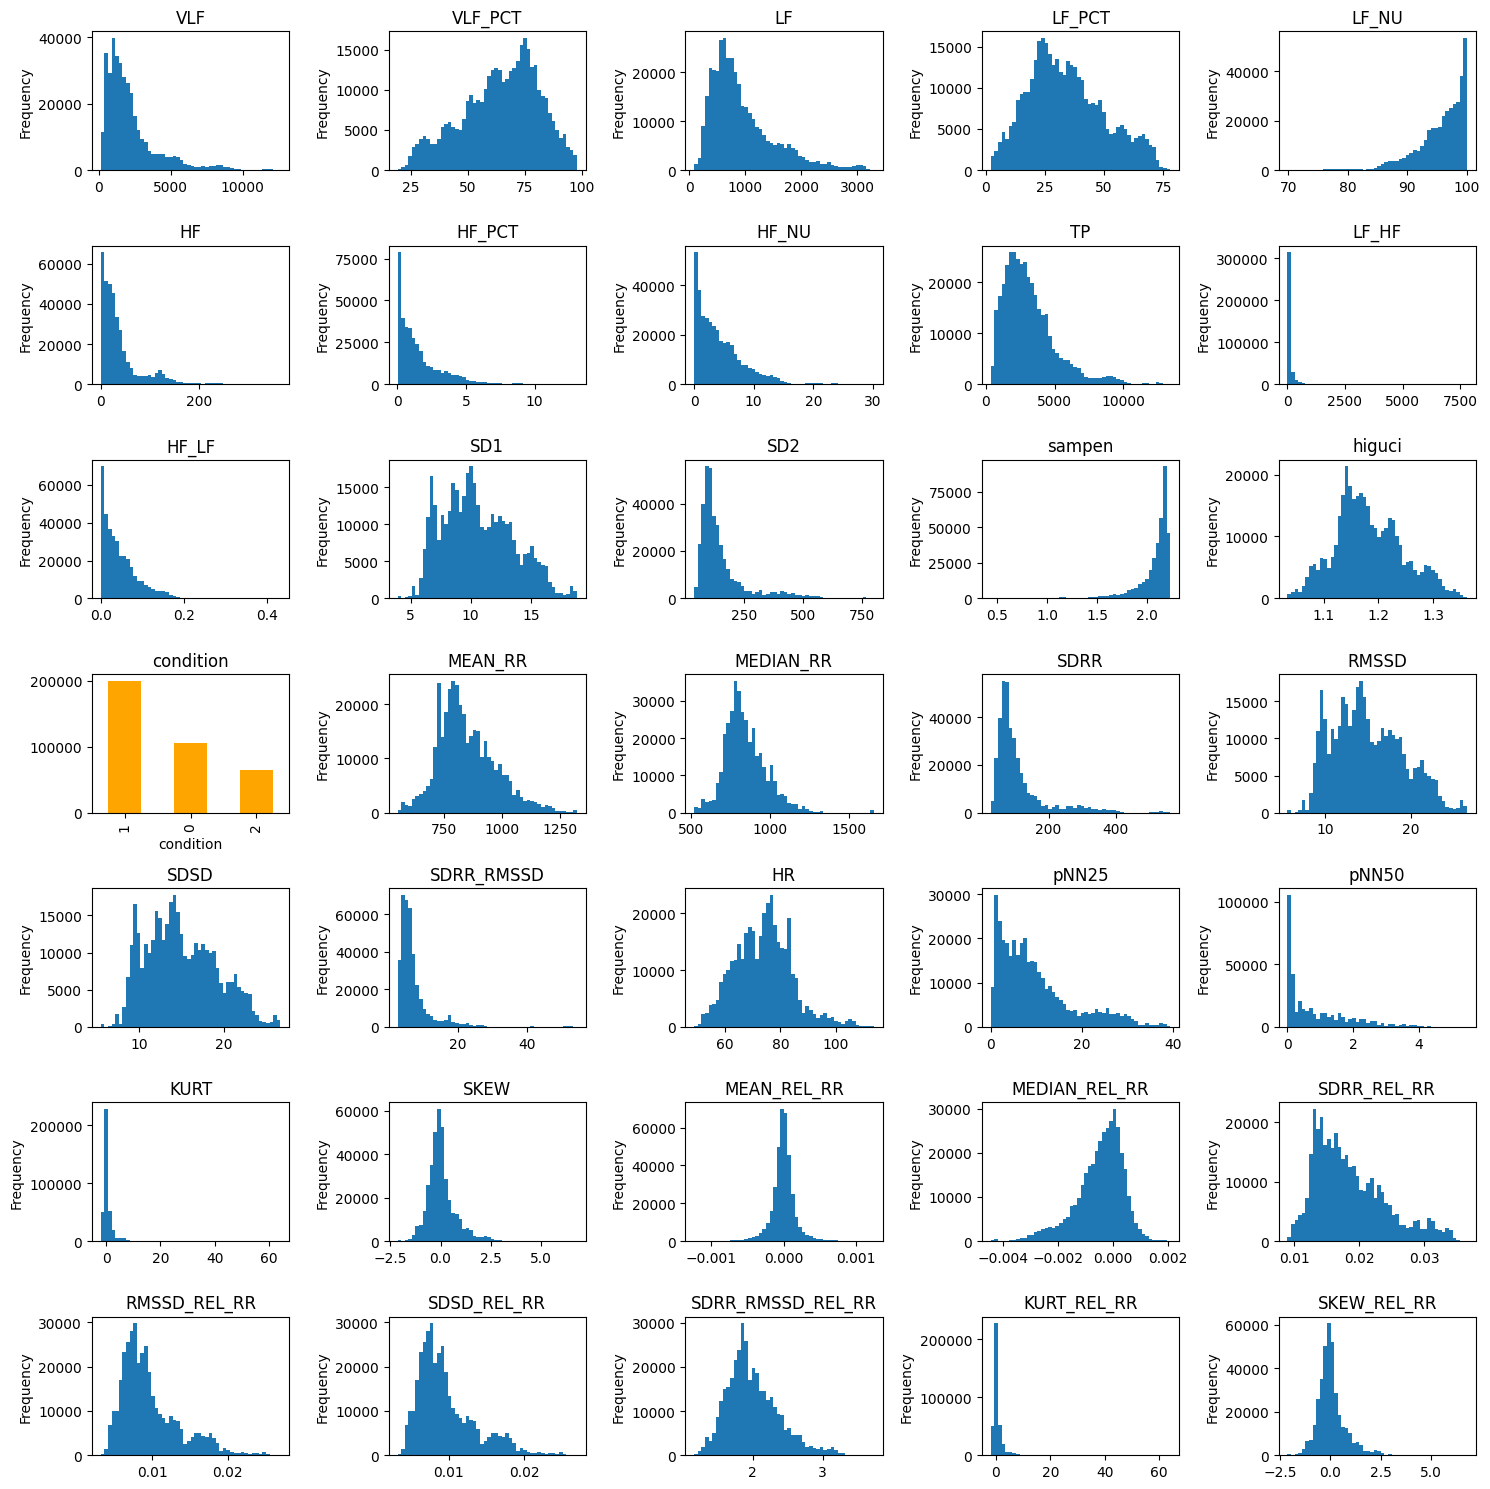

In [63]:
# plot histograms of the columns column by column
# using subplots to plot all the histograms in one figure
fig, axes = plt.subplots(7, 5, figsize=(15, 15))
for i, column in enumerate(df.columns):
    if column != 'condition':
        df[column].plot(kind='hist', ax=axes[i // 5, i % 5], title=column, bins=50)
    else:
        df['condition'].value_counts().plot(kind='bar', ax=axes[i // 5, i % 5], title='condition', color='orange')

plt.tight_layout()
plt.show()

In [76]:
# draw a correlation matrix
# make the condition column the last column
newdf = spark.createDataFrame(df)

assembler = VectorAssembler(inputCols=newdf.columns, outputCol='features')
output = assembler.transform(newdf)
corr = Correlation.corr(output, 'features').collect()[0][0]


In [90]:
# exclude the condition column from the correlation matrix
corr_matrix = corr.toArray()
corr_matrix = corr_matrix[:-1, :-1]


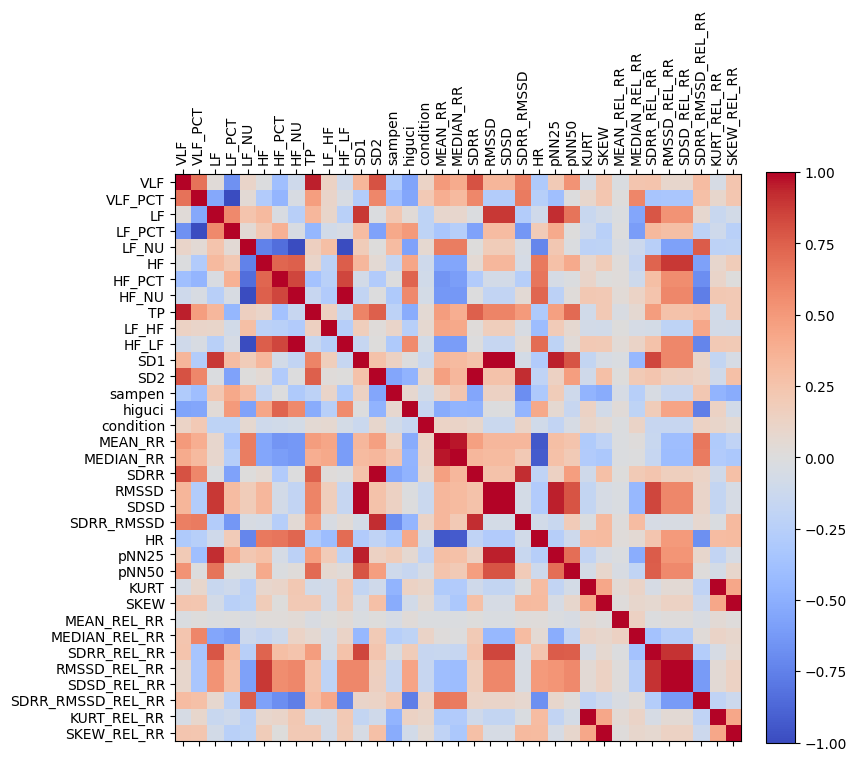

In [94]:
# plot the correlation matrix using matplotlib on big screen
# show the legend
# make the plot bigger

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(corr.toArray(), cmap='coolwarm')
plt.colorbar(cax, fraction=0.046, pad=0.04)
plt.xticks(range(len(df.columns)), df.columns, rotation=90)
plt.yticks(range(len(df.columns)), df.columns)
plt.show()
